In [3]:
import pykeen
import matplotlib.pyplot as plt
import numpy as np
from pykeen.pipeline import pipeline
# from pykeen.models import predict
# from pykeen.models.predict import get_prediction_df
from pykeen import  predict
from pykeen.datasets import Nations, Countries
from pykeen.pipeline.plot_utils import plot_er
from pykeen.triples import TriplesFactory


/home/serveradmin/_demo/pykeen-a-toy-example/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = Countries()
# dataset = Nations()


In [5]:
def entity_embedding_getter_TransE(model) -> pykeen.nn.Embedding:
    entity_representations_embedding = model.entity_representations[0]
    assert isinstance(entity_representations_embedding, pykeen.nn.Embedding)
    return entity_representations_embedding


def relation_embedding_getter_TransE(model) -> pykeen.nn.Embedding:
    relation_representations_embedding = model.relation_representations[0]
    assert isinstance(relation_representations_embedding, pykeen.nn.Embedding)
    return relation_representations_embedding


In [6]:
training = dataset.training
testing = dataset.testing
validation = dataset.validation

training


TriplesFactory(num_entities=271, num_relations=2, create_inverse_triples=False, num_triples=1110, path="/home/serveradmin/.data/pykeen/datasets/countries/train.txt")

In [ ]:
results = pipeline(
    training=training,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=150),
    optimizer_kwargs=dict(lr=0.01),
    training_kwargs=dict(num_epochs=1280, use_tqdm_batch=False),
    evaluation_kwargs=dict(batch_size=32, use_tqdm=False),
    random_seed=1,
    device='gpu',
)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <Axes: title={'center': 'Entity/Relation Plot using PCA'}>],
       dtype=object))

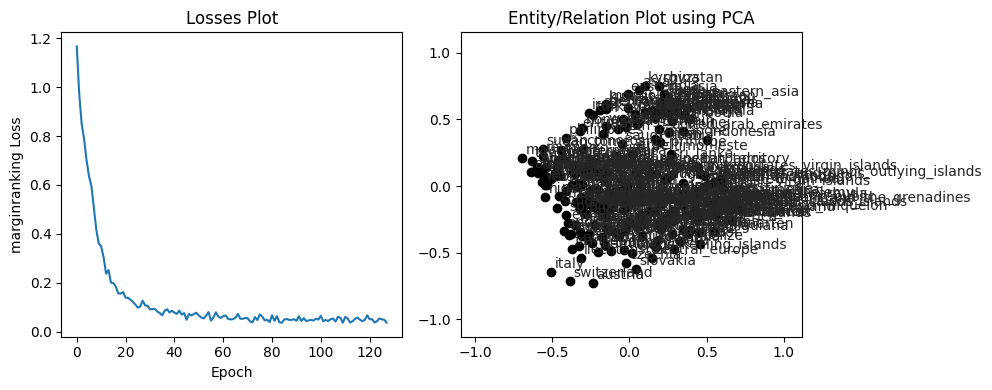

In [9]:
results.plot(
    er_kwargs=dict(
        plot_relations=True,
        entity_embedding_getter=entity_embedding_getter_TransE,
        relation_embedding_getter=relation_embedding_getter_TransE
    )
)

<Axes: title={'center': 'Entity/Relation Plot using PCA'}>

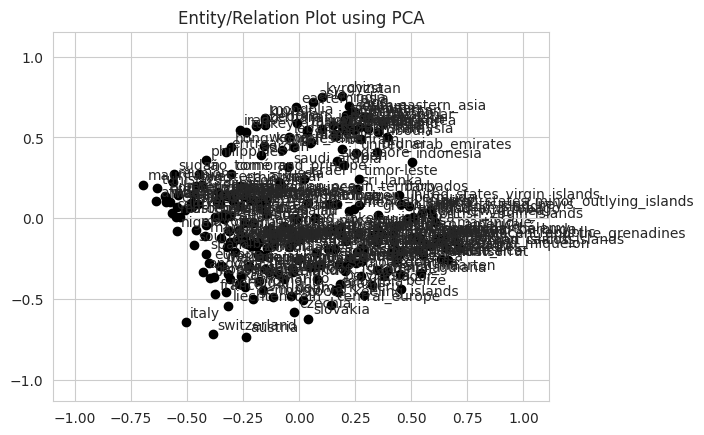

In [10]:
results.plot_er(
    plot_relations=True,
    relations={"reltreaties", "treaties", "conferences", "aidenemy"},
    entity_embedding_getter=entity_embedding_getter_TransE,
    relation_embedding_getter=relation_embedding_getter_TransE
)


# Nations Example

In [53]:
nations_results = pipeline(
    dataset="Countries",
    model="DistMult",
    model_kwargs=dict(embedding_dim=150),
    optimizer_kwargs=dict(lr=0.01),
    training_kwargs=dict(num_epochs=1280, use_tqdm_batch=False),
    evaluation_kwargs=dict(batch_size=32, use_tqdm=False),
    random_seed=1,
    device="cpu",
)

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///home/serveradmin/.data/pykeen/datasets/countries/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///home/serveradmin/.data/pykeen/datasets/countries/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///home/serveradmin/.data/pykeen/datasets/countries/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///home/serveradmin/.data/pykeen/datasets/countries/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
INFO:pykeen.pipeline.api:Using device: cpu
Training epochs on cpu: 100%|██████████| 1280/1280 [08:16<00:00,  2.58epoch/s, loss=0.163, prev_loss=0.168]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <Axes: title={'center': 'Entity/Relation Plot using PCA'}>],
       dtype=object))

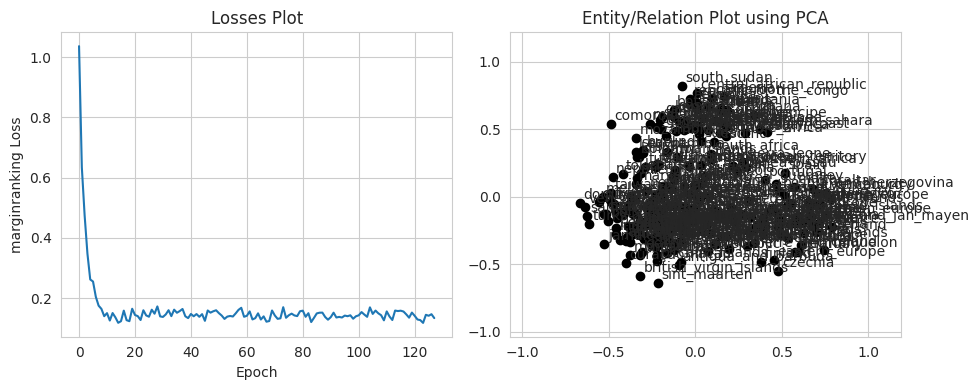

In [34]:
nations_results.plot(
    er_kwargs=dict(
        plot_relations=True,
        plot_entities=True,
        entity_embedding_getter=entity_embedding_getter_TransE,
        relation_embedding_getter=relation_embedding_getter_TransE
    )
)


<Axes: title={'center': 'Entity/Relation Plot using PCA'}>

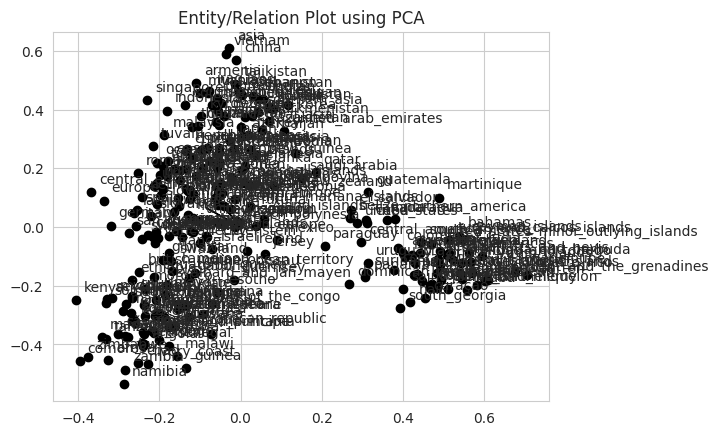

In [49]:
# Filter the ER plot down to a specific set of entities and relations
nations_results.plot_er(
    relations={"locatedin", "neighbor"},
    apply_limits=False,
    plot_relations=True,
    entity_embedding_getter=entity_embedding_getter_TransE,
    relation_embedding_getter=relation_embedding_getter_TransE
)


## Predict

### predict relations

In [56]:
predicted_relations_df = predict.predict_target(
    model=nations_results.model, 
    head="thailand", 
    tail="myanmar",
    triples_factory=nations_results.training,
)
predicted_relations_df.df.sort_values('score')

,relation_id,score,relation_label
0,0,-0.297521,locatedin
1,1,1.185762,neighbor


### predict tails

In [57]:
predicted_relations_df = predict.predict_target(
    model=nations_results.model, 
    head="thailand", 
    relation="neighbor",
    triples_factory=nations_results.training,
)
predicted_relations_df.df.sort_values("score", ascending=False)

,tail_id,score,tail_label
238,238,1.381310,thailand
38,38,1.261175,cambodia
125,125,1.253860,laos
261,261,1.191006,vietnam
158,158,1.185762,myanmar
...,...,...,...
42,42,-0.609458,caribbean
81,81,-0.647102,finland
175,175,-0.675345,norway
73,73,-0.676788,equatorial_guinea


# Toy Example

In [12]:
triples = """
Brussels	locatedIn	Belgium
Belgium	partOf	EU
EU	hasCapital	Brussels
""".strip()

triples = np.array([triple.split("\t") for triple in triples.split("\n")])
tf = TriplesFactory.from_labeled_triples(triples=triples)

INFO:pykeen.pipeline.api:Using device: cpu


Training epochs on cpu:   0%|          | 0/128 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>,
        <AxesSubplot: title={'center': 'Entity/Relation Plot'}>],
       dtype=object))

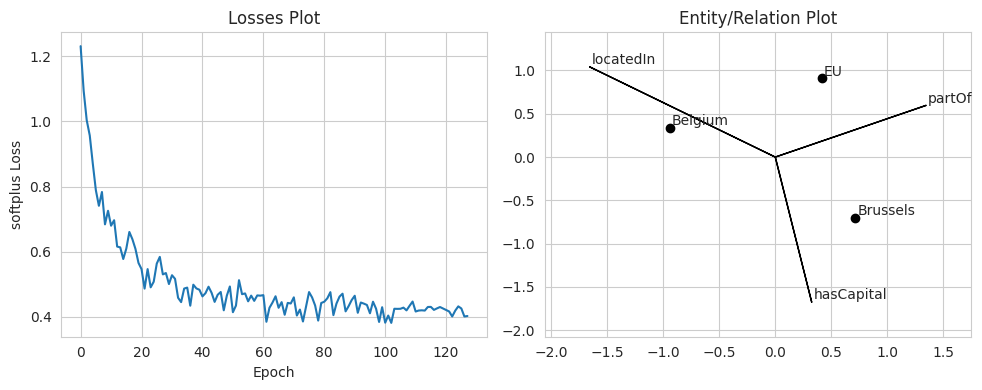

In [15]:
toy_results = pipeline(
    training=tf,
    testing=tf,
    model="TransE",
    loss="softplus",
    model_kwargs=dict(embedding_dim=2),
    optimizer_kwargs=dict(lr=1.0e-1),
    training_kwargs=dict(num_epochs=128, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=False),
    random_seed=1,
    device="cpu",
)

toy_results.plot(
    er_kwargs=dict(
        plot_relations=True, 
        entity_embedding_getter=entity_embedding_getter_TransE,
        relation_embedding_getter=relation_embedding_getter_TransE
    )
)


In [37]:
toy_predict_df = predict.get_prediction_df(
    model=toy_results.model,
    head_label="Belgium",
    tail_label="EU",
    triples_factory=tf,
)
toy_predict_df.sort_values(by='score').head()


,relation_id,relation_label,score,in_training
1,1,locatedIn,-3.477479,False
0,0,hasCapital,-3.281689,False
2,2,partOf,-0.033588,True


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("./friends.csv")
df

,Kate,like,arts
0,Alistair,like,arts
1,Alistair,like,sports
2,Henry,like,arts
3,Henry,like,comics
4,Henry,like,games
5,Gary,like,games
6,Gary,like,sports
7,Terry,like,sports
8,Colin,like,sports
9,Colin,like,games


In [6]:
from pykeen.triples.triples_factory import  TriplesFactory

In [7]:
# df[["head", "relation", "tail"]]
tf = TriplesFactory.from_labeled_triples(df.values)
tf

TriplesFactory(num_entities=12, num_relations=2, create_inverse_triples=False, num_triples=33)

In [8]:
training, testing, validation = tf.split([.8, .1, .1])


using automatically assigned random_state=3883156288


In [9]:
result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    # model_kwargs=dict(embedding_dim=20),
    # optimizer_kwargs=dict(lr=0.01),
    # training_kwargs=dict(num_epochs=1280, use_tqdm_batch=False),
    # evaluation_kwargs=dict(batch_size=32, use_tqdm=False),
    model_kwargs=dict(embedding_dim=2),
    random_seed=1,
    model='RotatE',
    stopper='early',
    epochs=120
)


No cuda devices were available. The model runs on CPU
Training epochs on cpu:   8%|▊         | 9/120 [00:01<00:20,  5.37epoch/s, loss=1.23, prev_loss=1.43]INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 1.0. Saved model weights to /home/serveradmin/.data/pykeen/checkpoints/best-model-weights-2134ef30-6d57-412b-aa92-12a7d4735d3e.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
Training epochs on cpu:  16%|█▌        | 19/120 [00:03<00:16,  6.13epoch/s, loss=1.17, prev_loss=1.26]INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefor

In [10]:
result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="RotatE",
    loss="softplus",
    stopper='early',
    model_kwargs=dict(embedding_dim=2),
    optimizer_kwargs=dict(lr=1.0e-1),
    training_kwargs=dict(num_epochs=128, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=False),
    random_seed=1,
    device="cpu",
)


INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/serveradmin/.data/pykeen/checkpoints/best-model-weights-14bebe91-26f2-437c-ac63-0ea21d02e0af.pt
Training epochs on cpu:   7%|▋         | 9/128 [00:01<00:18,  6.34epoch/s, loss=0.692, prev_loss=0.761]INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.07s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.75. Saved model weights to /home/serveradmin/.data/pykeen/checkpoints/best-model-weights-14bebe91-26f2-437c-ac63-0ea21d02e0af.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.
Training epochs on cpu:  15%|█▍        | 19/128 

In [11]:
result_prediction = predict.predict_target(
    model=result.model,
    head="Kate",
    relation="like",
    triples_factory=tf,
)
result_prediction.df


,tail_id,score,tail_label
5,5,-0.282142,Kate
1,1,-0.870075,Bill
10,10,-1.007440,games
2,2,-1.037802,Colin
8,8,-1.058030,arts
11,11,-1.058797,sports
6,6,-1.087133,Peter
4,4,-1.092767,Henry
7,7,-1.102365,Terry
0,0,-1.155397,Alistair


In [99]:
result_prediction = predict.predict_target(
    model=result.model,
    head="Kate",
    tail="Gary",
    triples_factory=tf,
)
result_prediction.df


,relation_id,score,relation_label
1,1,-1.161366,like
0,0,-2.045223,friend


/home/serveradmin/_demo/pykeen-a-toy-example/venv/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/serveradmin/_demo/pykeen-a-toy-example/venv/lib/python3.8/site-packages/matplotlib/transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/home/serveradmin/_demo/pykeen-a-toy-example/venv/lib/python3.8/site-packages/matplotlib/text.py:1475: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
/home/serveradmin/_demo/pykeen-a-toy-example/venv/lib/python3.8/site-packages/matplotlib/text.py:1477: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
/home/serveradmin/_demo/pykeen-a-toy-example/venv/lib/python3.8/site-packages/matplotlib/text.py:897: ComplexWarning: Cast

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>,
        <Axes: title={'center': 'Entity Plot'}>], dtype=object))

/home/serveradmin/_demo/pykeen-a-toy-example/venv/lib/python3.8/site-packages/matplotlib/text.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
/home/serveradmin/_demo/pykeen-a-toy-example/venv/lib/python3.8/site-packages/matplotlib/text.py:758: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


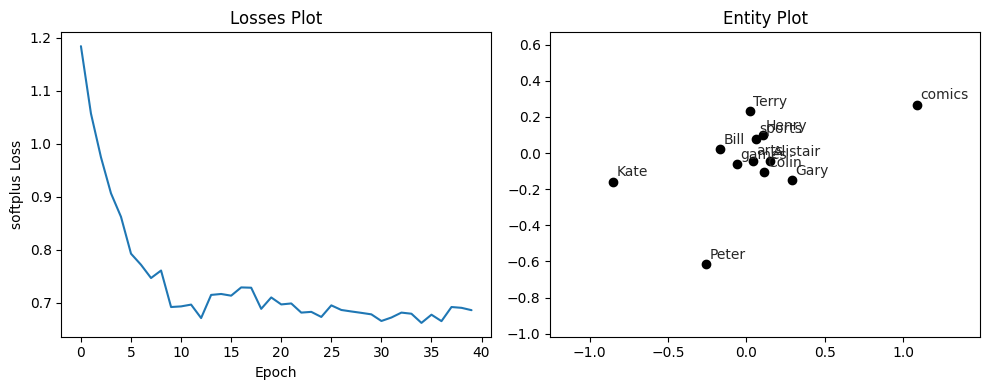

In [12]:
result.plot()
